# Problem Statement


WHO is a specialized agency of the UN which is concerned with the world population health. Based upon the various parameters, WHO allocates budget for various areas to conduct various campaigns/initiatives to improve healthcare. Annual salary is an important variable which is considered to decide budget to be allocated for an area.  
  
Extraction of data was done from 1994 Census dataset.  
  
The goal here is to build a binary model to predict whether the salary is >50K or <50K.

## Data Dictionary

1. <b>age:</b> age  
2. <b>workclass:</b> workclass  
3. <b>education:</b> highest education  
4. <b>marrital status:</b> marital status  
5. <b>occupation:</b> occupation  
6. <b>sex:</b> sex  
7. <b>capital gain:</b> income from investment sources other than salary/wages  
8. <b>capital loss:</b> income from investment sources other than salary/wages  
9. <b>working hours:</b> nummber of working hours per week  
10. <b>salary:</b> salary  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix
import warnings 
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("adult.data-1.csv")

### EDA

In [3]:
df.head()

,age,workclass,education,marrital status,occupation,sex,capital gain,capital loss,working hours per week,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Male,0,0,13,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Male,0,0,40,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Male,0,0,40,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Female,0,0,40,<=50K


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age                     32561 non-null  int64 
 1   workclass               32561 non-null  object
 2   education               32561 non-null  object
 3   marrital status         32561 non-null  object
 4   occupation              32561 non-null  object
 5   sex                     32561 non-null  object
 6   capital gain            32561 non-null  int64 
 7   capital loss            32561 non-null  int64 
 8   working hours per week  32561 non-null  int64 
 9   salary                  32561 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.5+ MB


There are no missing values. 6 variables are numeric and remaining categorical. Categorical variables are not in encoded format

### Check for duplicate data

In [6]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(df.shape)

Number of duplicate rows = 5864
(32561, 10)


Do we need to remove the duplicate data over here? We have removed the duplicate data but when are the cases that we remove duplicate data?

In [7]:
df.drop_duplicates(inplace=True) 

In [8]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(df.shape)

Number of duplicate rows = 0
(26697, 10)


### Geting unique counts of all Objects

In [9]:
for  feature in df.columns:
    if df[feature].dtype=='object':
         print(feature)
         print(df[feature].value_counts())
         print('\n')

workclass
Private             17474
Self-emp-not-inc     2447
Local-gov            1980
?                    1519
State-gov            1246
Self-emp-inc         1089
Federal-gov           921
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64


education
HS-grad         7815
Some-college    5692
Bachelors       4461
Masters         1606
Assoc-voc       1281
Assoc-acdm      1036
11th             987
10th             820
7th-8th          611
Prof-school      562
9th              502
Doctorate        399
12th             397
5th-6th          315
1st-4th          164
Preschool         49
Name: education, dtype: int64


marrital status
Married-civ-spouse       12679
Never-married             7698
Divorced                  3930
Separated                  978
Widowed                    971
Married-spouse-absent      418
Married-AF-spouse           23
Name: marrital status, dtype: int64


occupation
Prof-specialty       3703
Exec-managerial      3531
Sales       

In [10]:
# Replace ? marks
df['occupation']=df['occupation'].str.replace('?','unk')
df['workclass']=df['workclass'].str.replace('?','unk')

In [11]:
df.describe()

,age,capital gain,capital loss,working hours per week
count,26697.000000,26697.000000,26697.000000,26697.000000
mean,39.987489,1304.600929,105.699330,40.852530
std,13.691269,8111.031099,441.214823,13.114255
min,17.000000,0.000000,0.000000,1.000000
25%,29.000000,0.000000,0.000000,38.000000
50%,39.000000,0.000000,0.000000,40.000000
75%,49.000000,0.000000,0.000000,46.000000
max,90.000000,99999.000000,4356.000000,99.000000


In [11]:
df[df['capital gain']==0].shape[0]/df.shape[0]

0.8990148705847099

In [12]:
df[df['capital loss']==0].shape[0]/df.shape[0]

0.9435142525377384

### Checking the spread of the data using boxplot for the continuous variables.

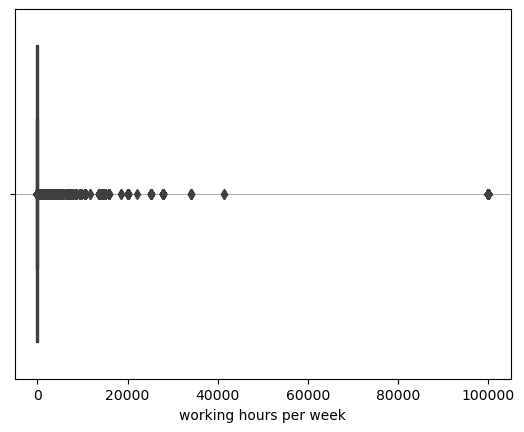

In [13]:
cols = ['age','capital gain','capital loss','working hours per week']
for i in cols:
    sns.boxplot(df[i])
    plt.grid();


### Treating the outliers.
###### We can treat Outliers with the following code. We will treat the outliers for the 'Age' variable only.

In [14]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [15]:
for column in df.columns:
     if df[column].dtype != 'object': 
         lr,ur=remove_outlier(df[column])
         df[column]=np.where(df[column]>ur,ur,df[column])
         df[column]=np.where(df[column]<lr,lr,df[column])

<AxesSubplot:xlabel='capital gain'>

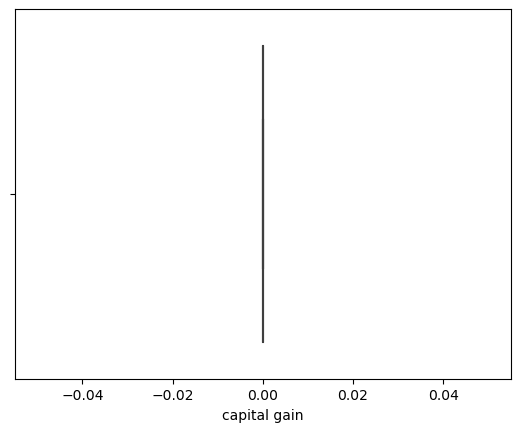

In [16]:
sns.boxplot(df['capital gain'])

In [17]:
## This is a loop to treat outliers for all the non-'object' type varible

# for column in df.columns:
#     if df[column].dtype != 'object': 
#         lr,ur=remove_outlier(df[column])
#         df[column]=np.where(df[column]>ur,ur,df[column])
#         df[column]=np.where(df[column]<lr,lr,df[column])

In [12]:
cols = ['age','capital gain','capital loss','working hours per week']



### Checking for Correlations.

In [19]:
correlation=df.corr()
correlation

,age,capital gain,capital loss,working hours per week
age,1.000000,NaN,NaN,0.038187
capital gain,NaN,NaN,NaN,NaN
capital loss,NaN,NaN,NaN,NaN
working hours per week,0.038187,NaN,NaN,1.000000


<AxesSubplot:>

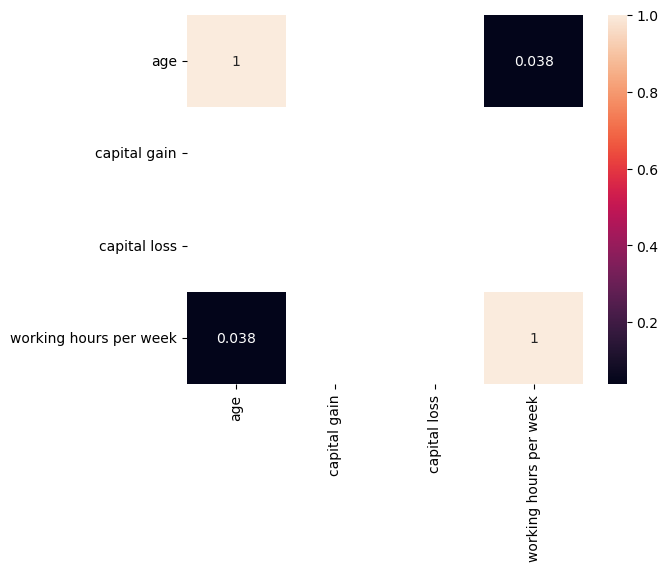

In [20]:
sns.heatmap(correlation,annot=True)

There is hardly any correlation between the numeric variables

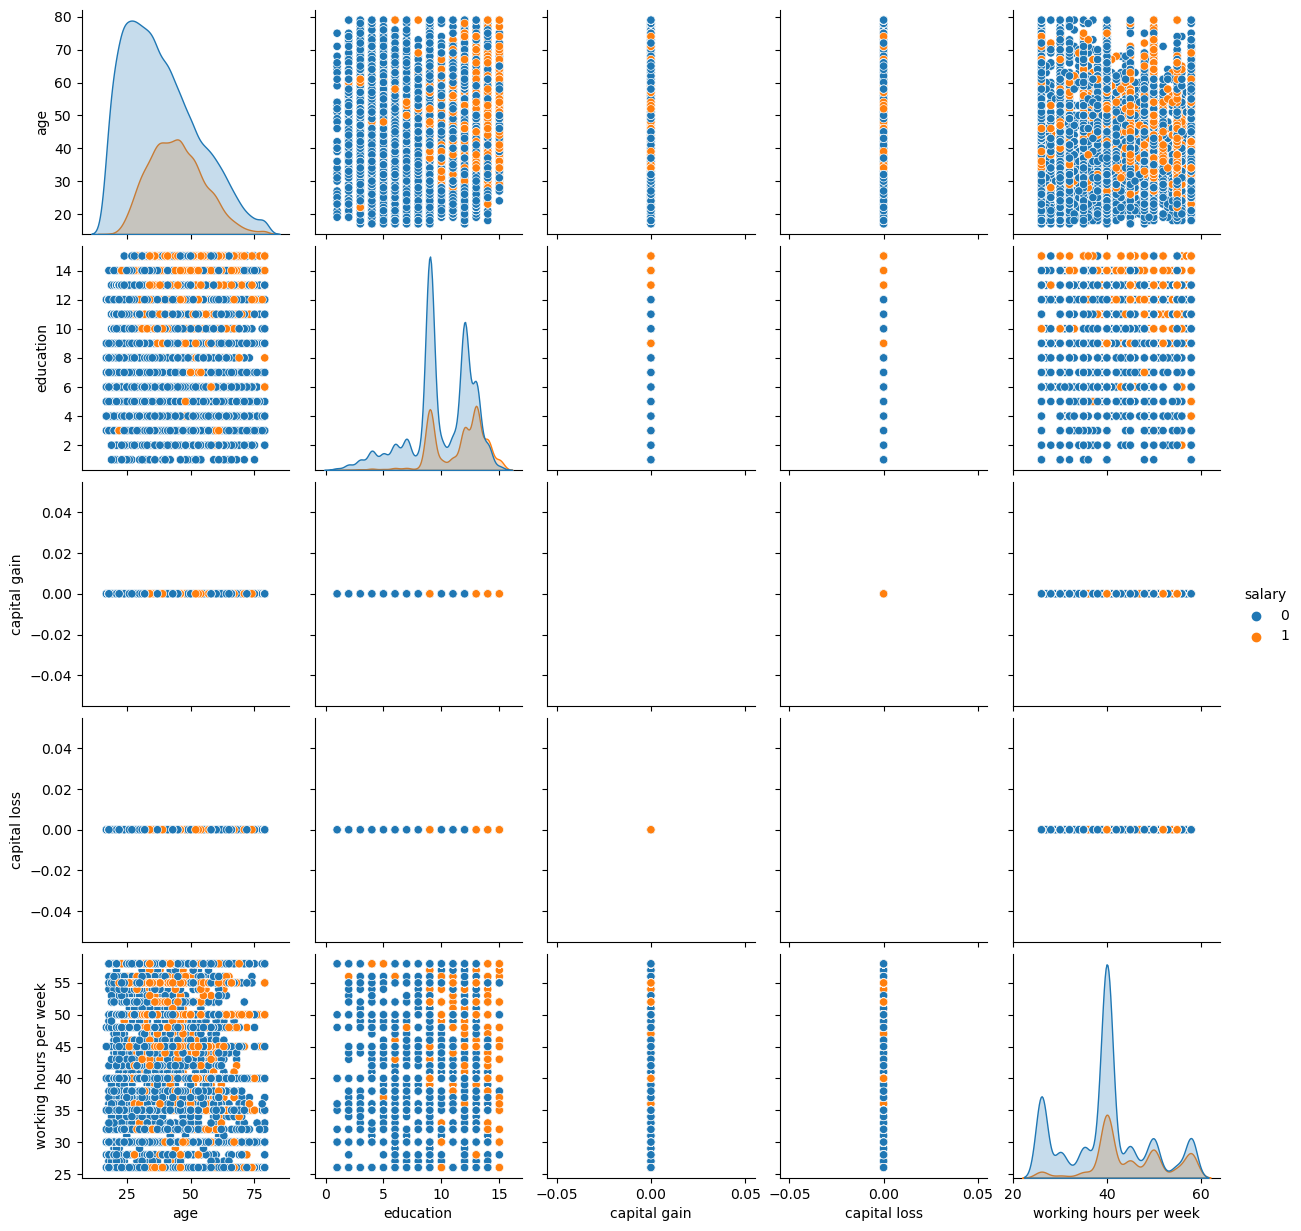

In [65]:
# Pairplot using sns
sns.pairplot(df,diag_kind='kde',hue='salary')

### Converting all objects to categorical codes

In [66]:
## We are coding up the 'education' variable in an ordinal manner

df['education']=np.where(df['education'] =='Preschool', '1', df['education'])
df['education']=np.where(df['education'] =='1st-4th', '2', df['education'])
df['education']=np.where(df['education'] =='5th-6th', '3', df['education'])
df['education']=np.where(df['education'] =='7th-8th', '4', df['education'])
df['education']=np.where(df['education'] =='9th', '5', df['education'])
df['education']=np.where(df['education'] =='10th', '6', df['education'])
df['education']=np.where(df['education'] =='11th', '7', df['education'])
df['education']=np.where(df['education'] =='12th', '8', df['education'])
df['education']=np.where(df['education'] =='HS-grad', '9', df['education'])
df['education']=np.where(df['education'] =='Prof-school', '9', df['education'])
df['education']=np.where(df['education'] =='Assoc-acdm', '10', df['education'])
df['education']=np.where(df['education'] =='Assoc-voc', '11', df['education'])
df['education']=np.where(df['education'] =='Some-college', '12', df['education'])
df['education']=np.where(df['education'] =='Bachelors', '13', df['education'])
df['education']=np.where(df['education'] =='Masters', '14', df['education'])
df['education']=np.where(df['education'] =='Doctorate', '15', df['education'])

In [67]:
## We are grouping certain types of 'workclass' under different categories

df['workclass']=np.where(df['workclass'] =='Federal-gov', 'Government', df['workclass'])
df['workclass']=np.where(df['workclass'] =='Local-gov', 'Government', df['workclass'])
df['workclass']=np.where(df['workclass'] =='State-gov', 'Government', df['workclass'])

df['workclass']=np.where(df['workclass'] =='Self-emp-inc', 'Others', df['workclass'])
df['workclass']=np.where(df['workclass'] =='Self-emp-not-inc', 'Others', df['workclass'])
df['workclass']=np.where(df['workclass'] =='unknown', 'Others', df['workclass'])
df['workclass']=np.where(df['workclass'] =='Without-pay', 'Others', df['workclass'])
df['workclass']=np.where(df['workclass'] =='Never-worked', 'Others', df['workclass'])

In [68]:
## We are grouping certain types of 'marritalstatus' under different categories

df['marrital status']=np.where(df['marrital status'] =='Divorced', 'CurrentlySingle', df['marrital status'])
df['marrital status']=np.where(df['marrital status'] =='Separated', 'CurrentlySingle', df['marrital status'])
df['marrital status']=np.where(df['marrital status'] =='Never-married', 'CurrentlySingle', df['marrital status'])
df['marrital status']=np.where(df['marrital status'] =='Widowed', 'CurrentlySingle', df['marrital status'])

df['marrital status']=np.where(df['marrital status'] =='Married-civ-spouse', 'Married', df['marrital status'])
df['marrital status']=np.where(df['marrital status'] =='Married-spouse-absent', 'Married', df['marrital status'])
df['marrital status']=np.where(df['marrital status'] =='Married-AF-absent', 'Married', df['marrital status'])
df['marrital status']=np.where(df['marrital status'] =='Married-AF-spouse', 'Married', df['marrital status'])

In [69]:
## We are grouping certain types of 'occupation' under different categories
df['occupation']=np.where(df['occupation'] =='Adm-clerical', 'WhiteCollar', df['occupation'])
df['occupation']=np.where(df['occupation'] =='Exec-managerial', 'WhiteCollar', df['occupation'])

df['occupation']=np.where(df['occupation'] =='Craft-repair', 'BlueCollar', df['occupation'])
df['occupation']=np.where(df['occupation'] =='Handlers-cleaners', 'BlueCollar', df['occupation'])
df['occupation']=np.where(df['occupation'] =='Transport-moving', 'BlueCollar', df['occupation'])
df['occupation']=np.where(df['occupation'] =='Farming-fishing', 'BlueCollar', df['occupation'])
df['occupation']=np.where(df['occupation'] =='Machine-op-inspct', 'BlueCollar', df['occupation'])

df['occupation']=np.where(df['occupation'] =='Tech-support', 'Service', df['occupation'])
df['occupation']=np.where(df['occupation'] =='Other-service', 'Service', df['occupation'])
df['occupation']=np.where(df['occupation'] =='Protective-serv', 'Service', df['occupation'])
df['occupation']=np.where(df['occupation'] =='Priv-house-serv', 'Service', df['occupation'])
df['occupation']=np.where(df['occupation'] =='Prof-specialty', 'Service', df['occupation'])

df['occupation']=np.where(df['occupation'] =='unknown', 'Unknown_Others', df['occupation'])
df['occupation']=np.where(df['occupation'] =='Armed-Forces', 'Unknown_Others', df['occupation'])


In [70]:
## Converting the education variable to numeric

df['education']=df['education'].astype(int)

In [71]:
## Converting the 'salary' Variable into numeric by using the LabelEncoder functionality inside sklearn.
from sklearn.preprocessing import LabelEncoder

## Defining a Label Encoder object instance
LE=LabelEncoder()

In [72]:
## Applying the created Label Encoder object for the target class
## Assigning the 0 to <=50k and 1 to >50k
df['salary']=LE.fit_transform(df['salary'])

In [82]:
df.head()

,age,workclass,education,marrital status,occupation,sex,capital gain,capital loss,working hours per week,salary
0,39.0,Government,13,CurrentlySingle,WhiteCollar,Male,0.0,0.0,40.0,0
1,50.0,Others,13,Married,WhiteCollar,Male,0.0,0.0,26.0,0
2,38.0,Private,9,CurrentlySingle,BlueCollar,Male,0.0,0.0,40.0,0
3,53.0,Private,7,Married,BlueCollar,Male,0.0,0.0,40.0,0
4,28.0,Private,13,Married,Service,Female,0.0,0.0,40.0,0


In [83]:
df['salary'].value_counts()

0    19673
1     7024
Name: salary, dtype: int64

In [75]:
# There is a class imbalance problem
df['salary'].value_counts(normalize=True)

0    0.736899
1    0.263101
Name: salary, dtype: float64

In [76]:
## Converting the other 'object' type variables as dummy variables
df_dummy=pd.get_dummies(df,drop_first=True)
df_dummy.head()

,age,education,capital gain,capital loss,working hours per week,salary,workclass_Others,workclass_Private,workclass_unk,marrital status_Married,occupation_Sales,occupation_Service,occupation_Unknown_Others,occupation_WhiteCollar,occupation_unk,sex_Male
0,39.0,13,0.0,0.0,40.0,0,0,0,0,0,0,0,0,1,0,1
1,50.0,13,0.0,0.0,26.0,0,1,0,0,1,0,0,0,1,0,1
2,38.0,9,0.0,0.0,40.0,0,0,1,0,0,0,0,0,0,0,1
3,53.0,7,0.0,0.0,40.0,0,0,1,0,1,0,0,0,0,0,1
4,28.0,13,0.0,0.0,40.0,0,0,1,0,1,0,1,0,0,0,0


### Train Test Split

In [77]:
# Copy all the predictor variables into X dataframe
X=df_dummy.drop('salary',axis=1)

# Copy target into the y dataframe. 
y=df_dummy['salary']

In [78]:
X.head()

,age,education,capital gain,capital loss,working hours per week,workclass_Others,workclass_Private,workclass_unk,marrital status_Married,occupation_Sales,occupation_Service,occupation_Unknown_Others,occupation_WhiteCollar,occupation_unk,sex_Male
0,39.0,13,0.0,0.0,40.0,0,0,0,0,0,0,0,1,0,1
1,50.0,13,0.0,0.0,26.0,1,0,0,1,0,0,0,1,0,1
2,38.0,9,0.0,0.0,40.0,0,1,0,0,0,0,0,0,0,1
3,53.0,7,0.0,0.0,40.0,0,1,0,1,0,0,0,0,0,1
4,28.0,13,0.0,0.0,40.0,0,1,0,1,0,1,0,0,0,0


In [79]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: salary, dtype: int64

In [80]:
# Split X and y into training and test set in 70:30 ratio
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=1)

In [81]:
y_train.value_counts(normalize=True)

0    0.738053
1    0.261947
Name: salary, dtype: float64

In [38]:
y_test.value_counts(normalize=True)

0    0.734207
1    0.265793
Name: salary, dtype: float64

### Logistic Regression Model

We are making some adjustments to the parameters in the Logistic Regression Class to get a better accuracy. Details of which can be found out on the site scikit-learn mentioned below

<a href='https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'>scikit-learn</a>

>Argument=solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
Algorithm to use in the optimization problem.

>For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

>For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

>‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty

>‘liblinear’ and ‘saga’ also handle L1 penalty

>‘saga’ also supports ‘elasticnet’ penalty

>‘liblinear’ does not support setting penalty='none'

>Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

>New in version 0.17: Stochastic Average Gradient descent solver.

>New in version 0.19: SAGA solver.

>Changed in version 0.22: The default solver changed from ‘liblinear’ to ‘lbfgs’ in 0.22.

<a href='https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451'> Article on Solvers</a>



In [39]:
# Fit the Logistic Regression model
model=LogisticRegression(verbose=True)
model.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


LogisticRegression(verbose=True)

### Predicting on Training and Test dataset

In [40]:
ytrain_predict=model.predict(X_train)
ytest_predict=model.predict(X_test)

In [41]:
ytrain_predict

array([0, 0, 0, ..., 0, 0, 1])

### Getting the Predicted Classes and Probs

In [42]:
ytrain_predict_prob=model.predict_proba(X_train)
ytest_predict_prob=model.predict_proba(X_test)

In [43]:
pd.DataFrame(ytrain_predict_prob).head()

,0,1
0,0.981249,0.018751
1,0.892082,0.107918
2,0.878616,0.121384
3,0.993450,0.006550
4,0.922483,0.077517


In [44]:
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.461777,0.538223
1,0.995157,0.004843
2,0.619859,0.380141
3,0.268428,0.731572
4,0.698548,0.301452


## Model Evaluation

In [45]:
# Accuracy - Training Data
round(model.score(X_train,y_train),2)

0.8

In [46]:
# Accuracy - Test Data
model.score(X_test,y_test)

0.7936329588014981

### AUC and ROC for the training data

AUC_Train 0.8473288092873784


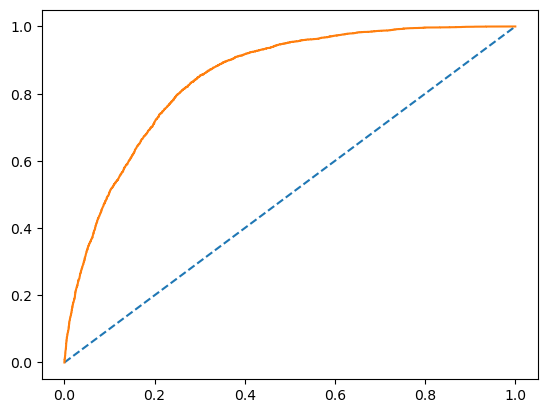

In [47]:
# predict probabilities
probs=model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs=probs[:,1]
# calculate AUC
auc=roc_auc_score(y_train,probs)
print('AUC_Train {}'.format(auc))
# calculate roc curve
train_FPR,train_TPR,threshold=roc_curve(y_train,probs)
plt.plot([0,1],[0,1],linestyle='--')
# plot the roc curve for the model
plt.plot(train_FPR,train_TPR)

In [48]:
# Accuracy - Test Data


### AUC and ROC for the test data

AUC_Test 0.8437396096640039


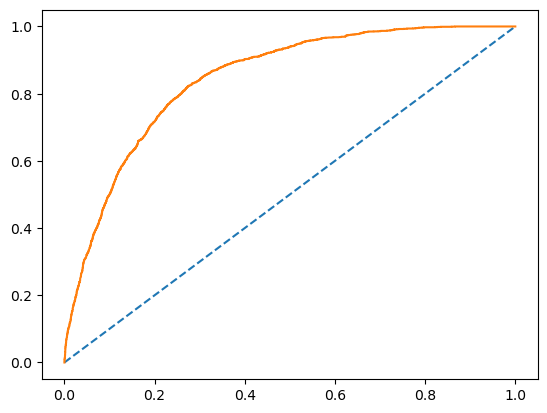

In [49]:
# predict probabilities
probs=model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs=probs[:,1]
# calculate AUC
auc=roc_auc_score(y_test,probs)
print('AUC_Test {}'.format(auc))
# calculate roc curve
test_FPR,test_TPR,threshold=roc_curve(y_test,probs)
plt.plot([0,1],[0,1],linestyle='--')
# plot the roc curve for the model
plt.plot(test_FPR,test_TPR)

### Confusion Matrix for the training data

In [50]:
confusion_matrix(y_train,ytrain_predict)

array([[12392,  1400],
       [ 2392,  2503]], dtype=int64)

<AxesSubplot:>

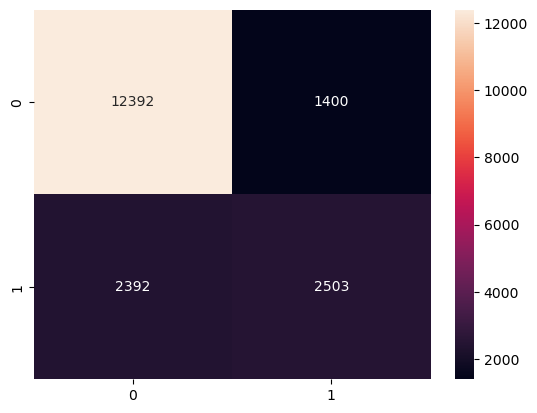

In [51]:
sns.heatmap(confusion_matrix(y_train,ytrain_predict),annot=True,fmt='g')

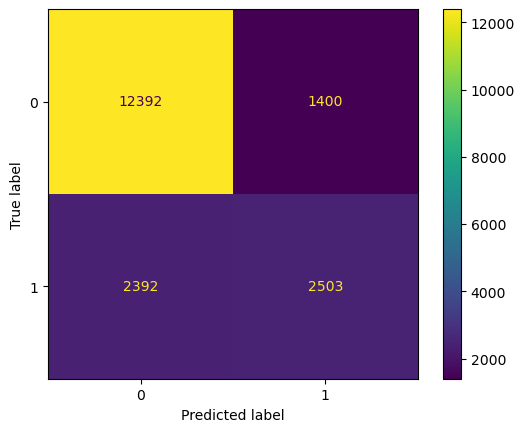

In [52]:
plot_confusion_matrix(model,X_train,y_train)

In [53]:
print(classification_report(y_train,ytrain_predict))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     13792
           1       0.64      0.51      0.57      4895

    accuracy                           0.80     18687
   macro avg       0.74      0.70      0.72     18687
weighted avg       0.79      0.80      0.79     18687



### Confusion Matrix for test data

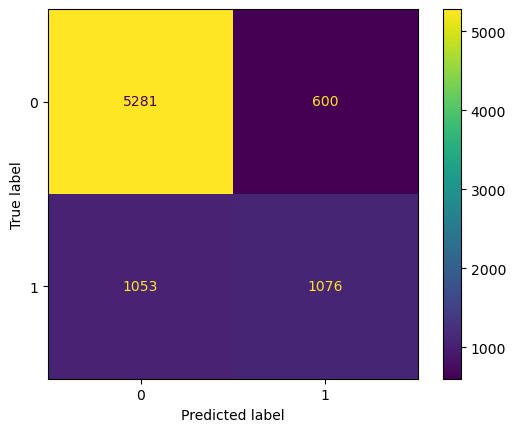

In [54]:
plot_confusion_matrix(model,X_test,y_test)

In [55]:
print(classification_report(y_test,ytest_predict))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      5881
           1       0.64      0.51      0.57      2129

    accuracy                           0.79      8010
   macro avg       0.74      0.70      0.72      8010
weighted avg       0.78      0.79      0.79      8010



## Applying GridSearchCV for Logistic Regression

In [61]:
grid={'penalty':['l1','l2','elasticnet','None'],
      'solver':['lbfgs','liblinear'],
      'tol':[0.01,0.001]}

In [62]:
model=LogisticRegression(max_iter=10000)
grid_search=GridSearchCV(estimator=model,param_grid=grid,cv=3,scoring='recall',n_jobs=-1)

In [63]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'solver': ['lbfgs', 'liblinear'],
                         'tol': [0.01, 0.001]},
             scoring='recall')

In [64]:
grid_search.best_params_

{'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.01}

In [84]:
best_model=grid_search.best_estimator_

In [85]:
best_model.score(X_train,y_train)

0.7992722213303366

In [86]:
best_model.score(X_test,y_test)

0.7955056179775281

In [94]:
y_train_predict=best_model.predict(X_train)
y_test_predict=best_model.predict(X_test)

In [95]:
# with grid search cv the performance increased by 2% in both train and test.

In [96]:
bal_model=LogisticRegression(penalty='12',solver='lbfgs',max_iter=10000,tol=0.01,class_weight='balanced')

In [97]:
bal_model.fit(X_train,y_train)

ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got 12.